In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random

import matplotlib.pyplot as plt

from sklearn.externals import joblib
import pickle

In [2]:
!pip install joblib

In [4]:
df = pd.read_csv(
    'ceneval_mentor_v3.csv',
    encoding='utf-8',
    low_memory=False,
    index_col=0
)

In [7]:
#get params
def get_random_params():
    return {
        "n_estimators": random.choice(range(10, 1000, 1)),
        "max_features": random.choice(range(50, 100, 5)) / 100,
        "max_depth": random.choice(list(range(1, 100, 1)) + [None]),
        "criterion": random.choice(['gini','entropy']),
        "n_jobs": -1
    }

# Create datasets
train = df.sample(frac=0.6)
temp = df.drop(train.index)
test = temp.sample(frac=0.5)
validate = temp.drop(test.index)

# Train data 
x_train = train.drop(["DICTAMEN"], axis=1)
y_train = train['DICTAMEN']

# Test data
x_test = test.drop(["DICTAMEN"], axis=1)
y_test = test['DICTAMEN']

# Validatation data
x_validate = validate.drop(["DICTAMEN"], axis=1)
y_validate = validate['DICTAMEN']

def get_accuracy(x_train, y_train, x_test, y_test, params): 
    clf=RandomForestClassifier(**params)
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    return metrics.accuracy_score(y_test, y_pred), clf

# Create random configurations for the model
params = []
best_model = None
best_score = -1
for i in range(1000):
    # Create random configuration
    param = get_random_params()
    # Get model and accuracy
    acc, model = get_accuracy(x_train, y_train, x_test, y_test, param)
    param["accuracy"] = acc
    # Save metadata
    params.append(param)
    # Get best model
    if acc > best_score:
      best_score = acc
      best_model = model

# Save results as csv
result = pd.DataFrame(params)
result.to_csv("results.csv", index=False)

In [8]:
# Save model as file
from joblib import dump, load
model_filename = 'best-model-{}.joblib'.format(best_score)
print("Saving model in file: {}".format(model_filename))
dump(best_model, model_filename) 


Saving model in file: best-model-0.7149263292761051.joblib


['best-model-0.7149263292761051.joblib']

In [9]:
clf = load(model_filename)
y_estimate_test = clf.predict(x_test)
y_estimate_validate = clf.predict(x_validate)
test_accuracy =  metrics.accuracy_score(y_test, y_estimate_test)
validate_accuracy = metrics.accuracy_score(y_validate, y_estimate_validate)
print("Accuracy test:", test_accuracy)
print("Accuracy validate:", validate_accuracy)


Accuracy test: 0.7149263292761051
Accuracy validate: 0.6951649055395454


# Matriz de Confusión

In [11]:
from sklearn.metrics import confusion_matrix
y_pred=clf.predict(x_test)
confusion_matrix(y_test, y_pred)


array([[ 945,  516],
       [ 374, 1287]], dtype=int64)

# Curva ROC

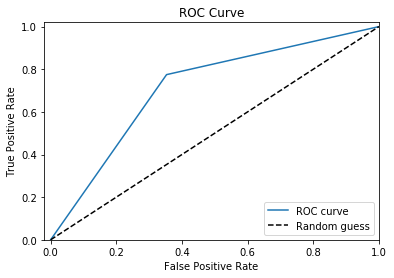

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

# save figure
plt.savefig('roc_curve.png', dpi=200)